In [1]:
!pip install dmba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 4.9 MB/s eta 0:00:00


In [2]:
#Import libraries here
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#Import google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Go to the directory where the files are present
%cd /content/drive/My Drive/DSBA 6211/Group Project

/content/drive/My Drive/DSBA 6211/Group Project


We had begun with a dataset containing historical daily prices for only 1 year for all tickers (companies) in Mega, Large, Mid and Small cap currently trading on S&P 500(stock prices of the 500 largest publicly traded companies in the United States). Below code is for the same. We did not go ahead for the reasons mentioned ahead in the comments therefore this code is commented.

In [ ]:
## Load data from csv files to dataframes
#df_large = pd.read_csv('large-cap-stocks-stocks-1y-test.csv', sep = '|')
#df_small = pd.read_csv('small-cap-stocks-stocks-1y-test.csv', sep = '|')
#df_mid = pd.read_csv('mid-cap-stocks-stocks-1y-test.csv', sep = '|')
#df_mega = pd.read_csv('megacap-stocks-stocks-1y-test.csv', sep = '|')

## Concatenate the 4 dataframes into a stocks dataframe
#stocks = pd.concat([df_small, df_mid, df_large, df_mega],ignore_index=True)

## Filter rows where symbol is 'MSFT'
#msft_df = stocks[stocks['Symbol'] == 'MSFT']

Realizing that,
1.	we need at least 5-10 years of data to find any trends and seasonality patterns in the behavior of the stock, and
2.	for now, assuming that the value of one stock is independent from the value and behavior of stock of any other ticker in the same cap and category,
we have limited the dataset to contain data for only company: Microsoft for our EDA and modelling for now. To be able to find the trends and seasonality patterns we have increased the scope of data to the last 10 years. The same EDA and modelling techniques can be applied to other Technology category stocks and used for a comparison and recommendation system as mentioned in our initial proposal.

In [4]:
# Read the Microsoft stock 10 years data from csv file into a dataframe
msft_df_10y = pd.read_csv('MSFT-10y.csv', sep = '|')
msft_df_10y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2517 non-null   object 
 1   Open       2517 non-null   float64
 2   High       2517 non-null   float64
 3   Low        2517 non-null   float64
 4   Close      2517 non-null   float64
 5   Adj Close  2517 non-null   float64
 6   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


In [5]:
# Take only last 5 years data
msft_df = msft_df_10y[-1261:]
msft_df

,Date,Open,High,Low,Close,Adj Close,Volume
1256,2019-03-27,117.879997,118.209999,115.519997,116.769997,111.152458,22733400
1257,2019-03-28,117.440002,117.580002,116.129997,116.930000,111.304764,18334800
1258,2019-03-29,118.070000,118.320000,116.959999,117.940002,112.266174,25399800
1259,2019-04-01,118.949997,119.110001,118.099998,119.019997,113.294220,22789100
1260,2019-04-02,119.059998,119.480003,118.519997,119.190002,113.456024,18142300
...,...,...,...,...,...,...,...
2512,2024-03-22,429.700012,429.859985,426.070007,428.739990,428.739990,17636500
2513,2024-03-25,425.239990,427.410004,421.609985,422.859985,422.859985,18060500
2514,2024-03-26,425.609985,425.989990,421.350006,421.649994,421.649994,16725600
2515,2024-03-27,424.440002,424.450012,419.010010,421.429993,421.429993,16705000


In [ ]:
# Convert Date column from string object to date datatype
msft_df['Date'] = pd.to_datetime(msft_df['Date'])
msft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 1256 to 2516
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1261 non-null   datetime64[ns]
 1   Open       1261 non-null   float64       
 2   High       1261 non-null   float64       
 3   Low        1261 non-null   float64       
 4   Close      1261 non-null   float64       
 5   Adj Close  1261 non-null   float64       
 6   Volume     1261 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.1 KB


<ipython-input-84-3047ab907e70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df['Date'] = pd.to_datetime(msft_df['Date'])


In [ ]:
# Checking for missing values
msft_df.isna().mean()*100

Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

**Trend:** In a time series, the trend component represents the long-term movement or pattern in the data. It captures the underlying direction or tendency of the data over time, ignoring short-term fluctuations, seasonality, and noise. The Microsoft stock exhibits an overall increasing trend except for the Covid period.

<Axes: xlabel='Date'>

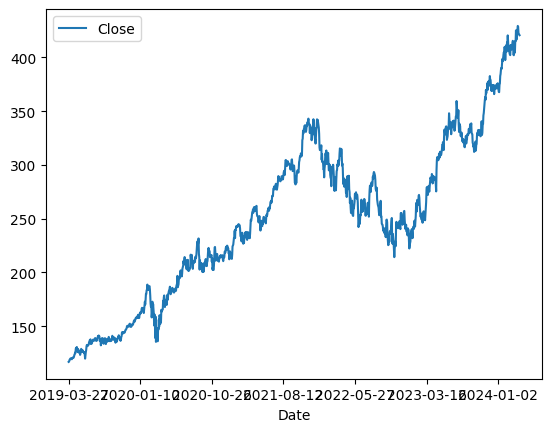

In [12]:
# Visualize microsoft stock prices
msft_df.plot.line(x= "Date",y="Close", use_index=True)

**Volatility:** Volatility is a measure of the variability or dispersion of returns, indicating the degree of fluctuation in the stock price. The Microsoft stock exhibits high volatility or significant trends over short periods, such as two years as shown in the ***Stock Daily Returns*** chart below which shows daily deviation or fluctuation in the stock price.

<ipython-input-87-678ae2af3001>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df['Daily Return'] = msft_df['Close'].pct_change() * 100  # Convert to percentage


<Axes: title={'center': 'Stock Daily Returns'}, xlabel='Date', ylabel='Daily Returns (%)'>

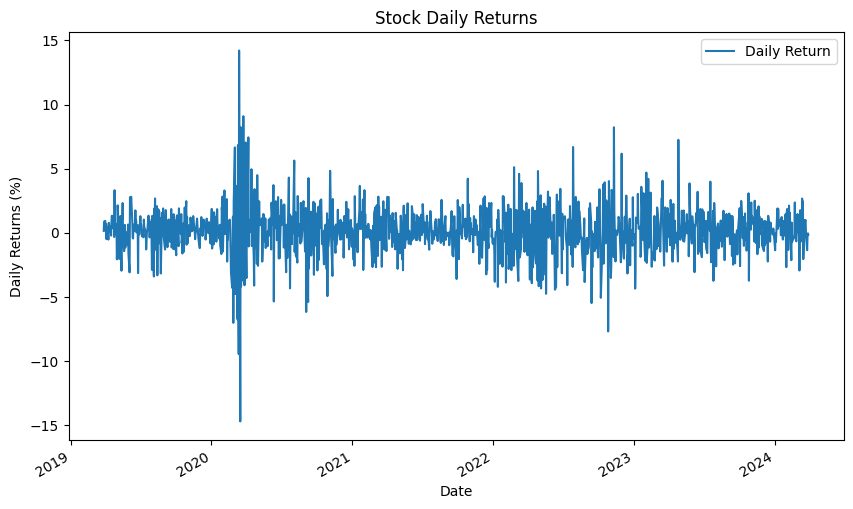

In [ ]:
# Calculate the daily returns of the stock using the closing prices. Daily returns are calculated as the percentage change in closing prices from one day to the next.
msft_df['Daily Return'] = msft_df['Close'].pct_change() * 100  # Convert to percentage
# Calculate volatility (standard deviation of daily returns)
volatility = msft_df['Daily Return'].std()

# Plot daily returns
# Plot volatility using Pandas' plot function
msft_df.plot(x='Date', y='Daily Return', figsize=(10, 6), title='Stock Daily Returns', xlabel='Date', ylabel='Daily Returns (%)')


From the above plots we see that the sharp decline in the price trend and the big dip in the daily stock value in the year 2020 due to Covid-19 is an anomaly. Since a pandemic is a very rare scenario, we have chosen to focus on analyzing the stock price from the beginning of 2021 to 2024 as the daily stock price fluctuation show a stationarity and no seasonality.

In [ ]:
# Take data from 2021 to 2024
msft_df = msft_df_10y[-814:]
msft_df

,Date,Open,High,Low,Close,Adj Close,Volume
1703,2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605316,37130100
1704,2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809448,23823000
1705,2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317352,35930700
1706,2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188522,27694500
1707,2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481369,22956200
...,...,...,...,...,...,...,...
2512,2024-03-22,429.700012,429.859985,426.070007,428.739990,428.739990,17636500
2513,2024-03-25,425.239990,427.410004,421.609985,422.859985,422.859985,18060500
2514,2024-03-26,425.609985,425.989990,421.350006,421.649994,421.649994,16725600
2515,2024-03-27,424.440002,424.450012,419.010010,421.429993,421.429993,16705000


**Random Forest Regressor** for stock price prediction

In [ ]:
# Adding a trend feature which is simply the difference of the close price of the previous and the current day
msft_df['Trend'] = msft_df['Close'].diff()
msft_df.dropna(inplace=True)
msft_df.head(50)

<ipython-input-90-4a55f1041ee4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df['Trend'] = msft_df['Close'].diff()
<ipython-input-90-4a55f1041ee4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_df.dropna(inplace=True)


,Date,Open,High,Low,Close,Adj Close,Volume,Trend
1705,2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317352,35930700,-5.649994
1706,2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188522,27694500,6.039993
1707,2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481369,22956200,1.330002
1708,2021-01-11,218.470001,218.910004,216.729996,217.490005,211.410904,23031300,-2.129990
1709,2021-01-12,216.500000,217.100006,213.320007,214.929993,208.922455,23249300,-2.560013
1710,2021-01-13,214.020004,216.759995,213.929993,216.339996,210.293015,20087100,1.410004
1711,2021-01-14,215.910004,217.460007,212.740005,213.020004,207.065842,29480800,-3.319992
1712,2021-01-15,213.520004,214.509995,212.029999,212.649994,206.706161,31746500,-0.370010
1713,2021-01-19,213.750000,216.979996,212.630005,216.440002,210.390259,30480900,3.790009
1714,2021-01-20,217.699997,225.789993,217.289993,224.339996,218.069458,37777300,7.899994


This data does not show any seasonality. The overall upward trend also comes with a lot of fluctuations. The volatility chart plotted above shows a lot of deviation in the daily price values too.
If for a moment, we  we try to use the existing features Open, High, Low, Adj Close and Volume to predict the stock price for the given day.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn import metrics

X = msft_df.drop(['Date','Close'], axis=1)
y = msft_df['Close']

nValid_rf = 30
nTrain_rf = len(msft_df) - nValid_rf
X_train_rf = X[:nTrain_rf]
y_train_rf = y[:nTrain_rf]
X_test_rf = X[nTrain_rf:]
y_test_rf = y[nTrain_rf:]
grid_rf = {'n_estimators': [25, 50, 75, 100, 200], 'max_depth': [2, 3], 'max_features': [4,6,8], 'random_state': [42]}
test_scores_rf = []

rf_model = RandomForestRegressor()

for g in ParameterGrid(grid_rf):
    rf_model.set_params(**g)
    rf_model.fit(X_train_rf, y_train_rf)
    test_scores_rf.append(rf_model.score(X_test_rf, y_test_rf))

best_index_rf = np.argmax(test_scores_rf)
print("Test scores for Random forest classifier:/n")
print(test_scores_rf[best_index_rf], ParameterGrid(grid_rf)[best_index_rf])


# Rerun with the best parameters
best_params_rf = np.prod(ParameterGrid(grid_rf)[best_index_rf])
rf_model = RandomForestRegressor(**best_params_rf)
rf_model.fit(X_train_rf, y_train_rf)

y_pred_rf = rf_model.predict(X_test_rf)

y_pred_series_rf = pd.Series(y_pred_rf, index=y_test_rf.index)

print('Mean Absolute Error for RandomForest:', metrics.mean_absolute_error(y_test_rf, y_pred_rf))
print('Mean Squared Error for RandomForest:', metrics.mean_squared_error(y_test_rf, y_pred_rf))
print('Root Mean Squared Error for RandomForest:', np.sqrt(metrics.mean_squared_error(y_test_rf, y_pred_rf)))

Test scores for Random forest classifier:/n
-1.3168423052369431 {'random_state': 42, 'n_estimators': 25, 'max_features': 4, 'max_depth': 3}
Mean Absolute Error for RandomForest: 9.918659199900635
Mean Squared Error for RandomForest: 156.3151374631844
Root Mean Squared Error for RandomForest: 12.50260522703906


<ipython-input-91-2ac26644f347>:26: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  print(test_scores_rf[best_index_rf], ParameterGrid(grid_rf)[best_index_rf])
<ipython-input-91-2ac26644f347>:30: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  best_params_rf = np.prod(ParameterGrid(grid_rf)[best_index_rf])


In [ ]:
msft_df[-40:]

,Date,Open,High,Low,Close,Adj Close,Volume,Trend
2477,2024-02-01,401.829987,408.000000,401.799988,403.779999,403.034698,30657700,6.200012
2478,2024-02-02,403.809998,412.649994,403.559998,411.220001,410.460968,28245000,7.440002
2479,2024-02-05,409.899994,411.160004,403.989990,405.649994,404.901245,25352300,-5.570007
2480,2024-02-06,405.880005,407.970001,402.910004,405.489990,404.741516,18382600,-0.160004
2481,2024-02-07,407.440002,414.299988,407.399994,414.049988,413.285706,22340500,8.559998
2482,2024-02-08,414.049988,415.559998,412.529999,414.109985,413.345612,21225300,0.059998
2483,2024-02-09,415.250000,420.820007,415.089996,420.549988,419.773712,22032800,6.440002
2484,2024-02-12,420.559998,420.739990,414.750000,415.260010,414.493500,21202900,-5.289978
2485,2024-02-13,404.940002,410.070007,403.390015,406.320007,405.570007,27824900,-8.940002
2486,2024-02-14,408.070007,409.839996,404.570007,409.489990,409.489990,20401200,3.169983


In [ ]:
y_pred_series_rf

2487    404.232514
2488    404.232514
2489    404.232514
2490    404.232514
2491    404.232514
2492    404.232514
2493    404.232514
2494    404.232514
2495    404.232514
2496    404.232514
2497    404.232514
2498    404.232514
2499    404.232514
2500    404.232514
2501    404.232514
2502    404.232514
2503    404.232514
2504    404.232514
2505    404.232514
2506    404.232514
2507    404.232514
2508    404.232514
2509    404.232514
2510    404.232514
2511    404.232514
2512    404.232514
2513    404.232514
2514    404.232514
2515    404.232514
2516    404.232514
dtype: float64

**TIME SERIES**

In [ ]:
# Creating a time series with date as the index
msft_ts = pd.Series(msft_df.Close.values, index=msft_df.Date, name='Close')

In [ ]:
msft_ts

Date
2021-01-06    212.250000
2021-01-07    218.289993
2021-01-08    219.619995
2021-01-11    217.490005
2021-01-12    214.929993
                 ...    
2024-03-22    428.739990
2024-03-25    422.859985
2024-03-26    421.649994
2024-03-27    421.429993
2024-03-28    420.720001
Name: Close, Length: 812, dtype: float64

**Seasonality:** The below plot for last 2 years does not show any seasonlity.

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(-50.0, 0, '2024-01-18'),
  Text(0.0, 0, '2023-01-04'),
  Text(50.0, 0, '2023-03-17'),
  Text(100.0, 0, '2023-05-30'),
  Text(150.0, 0, '2023-08-10'),
  Text(200.0, 0, '2023-10-20'),
  Text(250.0, 0, '2024-01-03'),
  Text(300.0, 0, '2024-03-15'),
  Text(350.0, 0, '')])

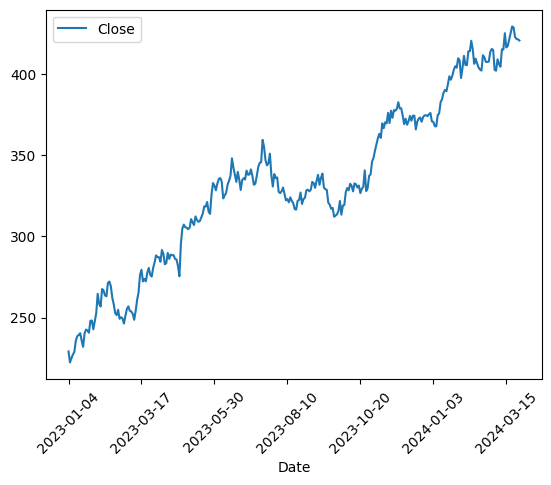

In [ ]:
# Visualize seasonality in last 2 years data
msft_df[(len(msft_df) - 310):].plot.line(x= "Date",y="Close", use_index=True)
plt.xticks(rotation=45)

In [ ]:
# Model 1: A linear trend time series model
import statsmodels.formula.api as sm
from statsmodels.tsa import tsatools, stattools

ts_df = tsatools.add_trend(msft_ts,trend='ctt')  # "ct" adds both constant and trend

# Calculate the difference with a lag of 1
ts_df['lag1'] = msft_ts - msft_ts.shift(1)

ts_df.dropna(inplace=True)

# display updated ts_df
ts_df

,Close,const,trend,trend_squared,lag1
Date,,,,,
2021-01-07,218.289993,1.0,2.0,4.0,6.039993
2021-01-08,219.619995,1.0,3.0,9.0,1.330002
2021-01-11,217.490005,1.0,4.0,16.0,-2.129990
2021-01-12,214.929993,1.0,5.0,25.0,-2.560013
2021-01-13,216.339996,1.0,6.0,36.0,1.410004
...,...,...,...,...,...
2024-03-22,428.739990,1.0,808.0,652864.0,-0.630005
2024-03-25,422.859985,1.0,809.0,654481.0,-5.880005
2024-03-26,421.649994,1.0,810.0,656100.0,-1.209991


In [ ]:
# Using the last 30 days data for validation from msft time series with constant and trend
nValid = 30
nTrain = len(ts_df) - nValid
train_ts = ts_df[:nTrain]
valid_ts = ts_df[nTrain:]

In [ ]:
# fit a linear regression model
msft_lm = sm.ols(formula='Close ~ trend', data=train_ts).fit()
print(msft_lm.summary())

from dmba import regressionSummary
predict_lm = msft_lm.predict(valid_ts)
regressionSummary(valid_ts["Close"],predict_lm)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     378.2
Date:                Sun, 05 May 2024   Prob (F-statistic):           5.70e-69
Time:                        20:22:29   Log-Likelihood:                -3924.2
No. Observations:                 781   AIC:                             7852.
Df Residuals:                     779   BIC:                             7862.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    246.2711      2.645     93.113      0.0

In [ ]:
# fit a linear regression model
msft_lm_1 = sm.ols(formula='Close ~ trend + trend_squared', data=train_ts).fit()
print(msft_lm_1.summary())

from dmba import regressionSummary
predict_lm_1 = msft_lm_1.predict(valid_ts)
regressionSummary(valid_ts["Close"],predict_lm_1)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     289.9
Date:                Sun, 05 May 2024   Prob (F-statistic):           8.21e-95
Time:                        20:24:43   Log-Likelihood:                -3861.2
No. Observations:                 781   AIC:                             7728.
Df Residuals:                     778   BIC:                             7742.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       278.3896      3.680     75.648

In [ ]:
# fit a linear regression model
msft_lm_2 = sm.ols(formula='Close ~ trend + np.power(trend,3)', data=train_ts).fit()
print(msft_lm_2.summary())

predict_lm_2 = msft_lm_2.predict(valid_ts)
regressionSummary(valid_ts["Close"],predict_lm_2)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                     379.0
Date:                Sun, 05 May 2024   Prob (F-statistic):          1.19e-115
Time:                        20:25:26   Log-Likelihood:                -3813.1
No. Observations:                 781   AIC:                             7632.
Df Residuals:                     778   BIC:                             7646.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            278.8890      3

In [ ]:
# fit a linear regression model
msft_lm_3 = sm.ols(formula='Close ~ trend + np.power(trend,4)', data=train_ts).fit()
print(msft_lm_3.summary())

predict_lm_3 = msft_lm_3.predict(valid_ts)
regressionSummary(valid_ts["Close"],predict_lm_3)

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     454.4
Date:                Sun, 05 May 2024   Prob (F-statistic):          1.85e-131
Time:                        20:25:59   Log-Likelihood:                -3776.5
No. Observations:                 781   AIC:                             7559.
Df Residuals:                     778   BIC:                             7573.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            277.5230      2

Checking for stationarity in the dataset with Dickey Fuller Augmentation Test. The p-value is 0.90 which shows that the series is not stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
msft_adf_test = adfuller(msft_ts,autolag='AIC')
msft_adf_op = pd.Series(msft_adf_test[0:4],index=['Test Statistic', 'p-value', '#lags used', 'Number of observations Used'])

for key , value in msft_adf_test[4].items(): msft_adf_op['Critical Value (%s)'%key] = value
print(msft_adf_op)

Results of Dickey-Fuller Test:
Test Statistic                  -0.445029
p-value                          0.902305
#lags used                       2.000000
Number of observations Used    809.000000
Critical Value (1%)             -3.438459
Critical Value (5%)             -2.865119
Critical Value (10%)            -2.568676
dtype: float64


In [ ]:
msft_ts_diff = pd.DataFrame(np.diff(msft_ts,1))

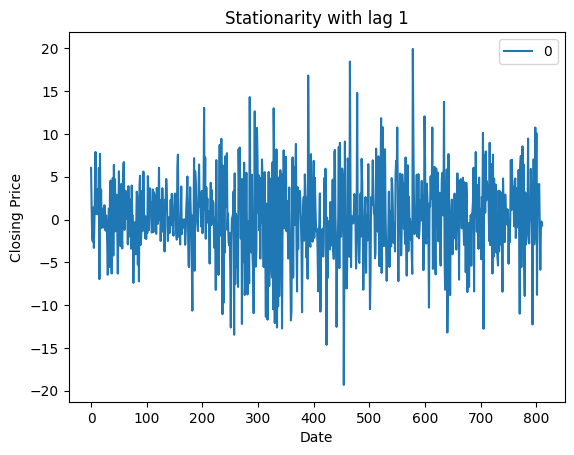

In [ ]:
import numpy as np
ax = msft_ts_diff.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price')
ax.set_title("Stationarity with lag 1")
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
print('Results of Dickey-Fuller Test:')
msft_adf_test = adfuller(msft_ts_diff,autolag='AIC')
msft_adf_op = pd.Series(msft_adf_test[0:4],index=['Test Statistic', 'p-value', '#lags used', 'Number of observations Used'])

for key , value in msft_adf_test[4].items(): msft_adf_op['Critical Value (%s)'%key] = value
print(msft_adf_op)

Results of Dickey-Fuller Test:
Test Statistic                 -22.084295
p-value                          0.000000
#lags used                       1.000000
Number of observations Used    809.000000
Critical Value (1%)             -3.438459
Critical Value (5%)             -2.865119
Critical Value (10%)            -2.568676
dtype: float64


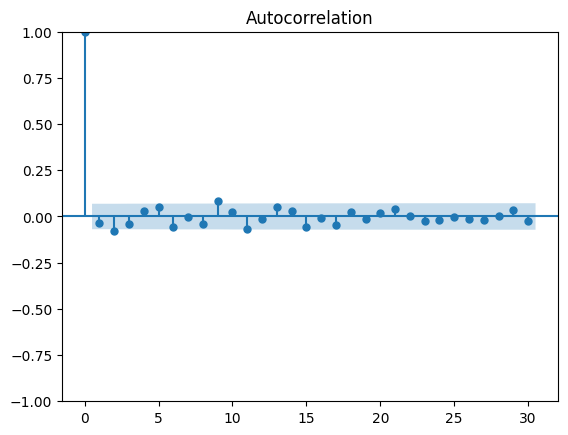

In [ ]:
#Plot the ACF plot
import statsmodels.tsa.api as smt
#msft_ts_log_diff = msft_ts_log.diff(periods= 1)
msft_ts_diff.dropna(inplace=True)
smt.graphics.plot_acf(msft_ts_diff, lags=30, alpha= 0.05)
plt.show() #q=1

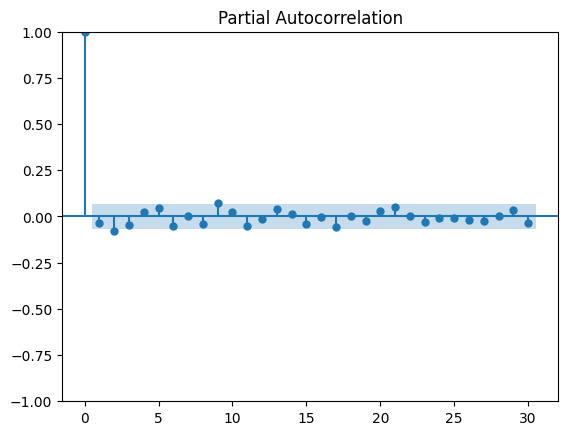

In [ ]:
#PACF plot
smt.graphics.plot_pacf(msft_ts_diff, lags=30, alpha= 0.05)
plt.show() #p=1

In [ ]:
# Data partition for the time series data
# Keep the last three years data as the validation dataset
#nValid = 30
#nTrain = len(msft_ts) - nValid
#train_ts = msft_ts[:nTrain]
#valid_ts = msft_ts[nTrain:]

In [ ]:
# Test a SARIMA model
import statsmodels.api as sm
temp_model = sm.tsa.statespace.SARIMAX(msft_df["Close"],
                                       order=(1,1,1),
                                       seasonal_order=(0,0,0,0), # Since the time series shows no seasonality, the seasonality component is 0
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)
results = temp_model.fit()
print(results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  812
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2433.982
Date:                Sun, 05 May 2024   AIC                           4873.964
Time:                        20:38:41   BIC                           4888.059
Sample:                             0   HQIC                          4879.375
                                - 812                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5551      0.342      1.625      0.104      -0.114       1.225
ma.L1         -0.6108      0.328     -1.863      0.062      -1.253       0.032
sigma2        23.6777      0.996     23.761      0.0

In [ ]:
pred = results.get_forecast(steps=30,alpha=0.05)

# Get the forecasted values
forecasted_values = pred.predicted_mean

# Get the confidence intervals for the forecasted values
confidence_intervals = pred.conf_int()

forecasted_values

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


812    420.833204
813    420.896042
814    420.930922
815    420.950283
816    420.961030
817    420.966995
818    420.970307
819    420.972145
820    420.973165
821    420.973732
822    420.974046
823    420.974220
824    420.974317
825    420.974371
826    420.974401
827    420.974418
828    420.974427
829    420.974432
830    420.974435
831    420.974436
832    420.974437
833    420.974438
834    420.974438
835    420.974438
836    420.974438
837    420.974438
838    420.974438
839    420.974438
840    420.974438
841    420.974438
Name: predicted_mean, dtype: float64

In [ ]:
from dmba import regressionSummary
regressionSummary(valid_ts['Close'], pred.predicted_mean)


Regression statistics

                      Mean Error (ME) : -7.3055
       Root Mean Squared Error (RMSE) : 10.9848
            Mean Absolute Error (MAE) : 9.1798
          Mean Percentage Error (MPE) : -1.8060
Mean Absolute Percentage Error (MAPE) : 2.2449


In [ ]:
forecasted_values_df = pd.DataFrame(forecasted_values)

In [ ]:
forecasted_values_df

,predicted_mean
1231,409.513713
1232,409.519380
1233,409.520734
1234,409.521058
1235,409.521135
1236,409.521153
1237,409.521158
1238,409.521159
1239,409.521159
1240,409.521159


In [ ]:
pred = results.get_forecast(steps=44,alpha=0.05)

# Get the forecasted values
forecasted_values_pred = pred.predicted_mean

# Get the confidence intervals for the forecasted values
confidence_intervals_pred = pred.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


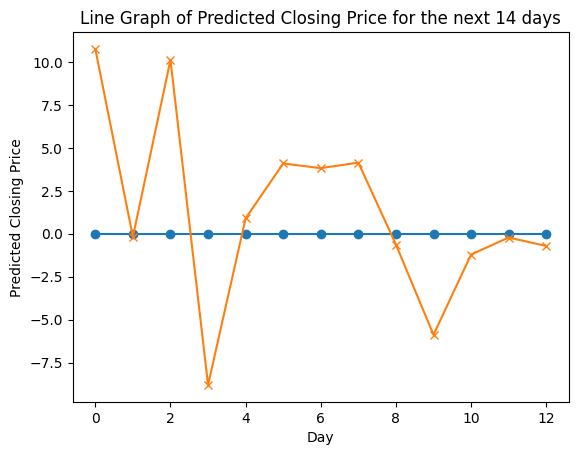

In [ ]:
# Plotting the line graph
plt.plot(np.diff(forecasted_values_df['predicted_mean'][16:],1),label='Forecasted', marker='o')
# Plot predicted values
plt.plot(np.diff(valid_ts["Close"][16:],1), label='Actual', marker='x')


# Adding labels and title
plt.xlabel('Day')
plt.ylabel('Predicted Closing Price')
plt.title('Line Graph of Predicted Closing Price for the next 14 days')

# Display the plot
plt.show()

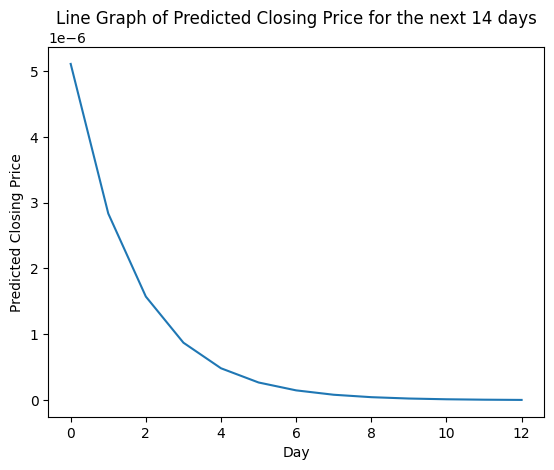

In [ ]:
plt.plot(np.diff(forecasted_values_df['predicted_mean'][16:],1))

# Adding labels and title
plt.xlabel('Day')
plt.ylabel('Predicted Closing Price')
plt.title('Line Graph of Predicted Closing Price for the next 14 days')

# Display the plot
plt.show()

In [ ]:
# Search for best parameters for SARIMA
# generate the parameter combinations
# Define the p, d and q parameters to take any value between 0 and 2
import itertools

p = d = q = range(0,2)

# Generate all possible combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all possible combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p, d, q))]

print(pdq)
print(seasonal_pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [ ]:
import sys
# Specify to ignore warning messages
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
print("Start search time:", datetime.now())

# Set up the initial values
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

import statsmodels.api as sm
# Using loops to search for the best SARIMA model
# Choose the best SARIMA model based on minimum AIC values
# AIC: to balance the model between goodness-of-fit and number of parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = sm.tsa.statespace.SARIMAX(train_ts,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)
            results = temp_model.fit()

            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal

        except:
            continue

print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

print("End search time:", datetime.now())

Start search time: 2024-05-05 20:40:12.457373
Best SARIMAXNonexNone12 model - AIC:inf
End search time: 2024-05-05 20:40:12.629202
